# Test to read Modtran output data
=====================================================
- author Sylvie Dagoret-Campagne
- affiliation : LAL/IN2P3/CNRS
- date : May 24th 2017

Found the technique to read Modtran from python at :
http://nullege.com/codes/show/src@p@y@pyradi-0.1.44@pyradi@rymodtran.py

I have adapted it to read our Modtran LSST files


In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import pandas as pd
import os
import re

In [3]:
from string import maketrans
import StringIO

In [4]:
# to enlarge the sizes
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (10, 8),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

In [5]:
file_modtran='Pachondat/Pachon_MODTRAN.10.7sc'

In [6]:
##############################################################################
##http://stackoverflow.com/questions/1324067/how-do-i-get-str-translate-to-work-with-unicode-strings
def fixHeaders(instr):
    """
    Modifies the column header string to be compatible with numpy column lookup.
  
    Args:
        | list columns (string): column name.
  
  
    Returns:
        | list columns (string): fixed column name.
  
    Raises:
        | No exception is raised.
    """
  
    intab = u"+-[]@"
    outtab = u"pmbba"
  
    if isinstance(instr, unicode):
        translate_table = dict((ord(char), unicode(outtab)) for char in intab)
    else:
        assert isinstance(instr, str)
        translate_table = maketrans(intab, outtab)
    return instr.translate(translate_table)
  
  

In [7]:
##############################################################################
##
def fixHeadersList(headcol):
    """
    Modifies the column headers to be compatible with numpy column lookup.
  
    Args:
        | list columns ([string]): list of column names.
  
  
    Returns:
        | list columns ([string]): fixed list of column names.
  
    Raises:
        | No exception is raised.
    """
  
    headcol = [fixHeaders(str) for str in headcol]
    return headcol
  
##############################################################################
##

In [8]:
##############################################################################
##
def loadtape7(filename, colspec = []):
  
    """
    Read the Modtran tape7 file. This function was tested with Modtran5 files.
  
    Args:
        | filename (string): name of the input ASCII flatfile.
        | colspec ([string]): list of column names required in the output the spectral transmittance data.
  
    Returns:
        | np.array: an array with the selected columns. Col[0] is the wavenumber.
  
    Raises:
        | No exception is raised.
  
  
  
    This function reads in the tape7 file from MODerate spectral resolution
    atmospheric TRANsmission (MODTRAN) code, that is used to model the
    propagation of the electromagnetic radiation through the atmosphere. tape7
    is a primary file that contains all the spectral results of the MODTRAN
    run. The header information in the tape7 file contains portions of the
    tape5 information that will be deleted. The header section in tape7 is
    followed by a list of spectral points with corresponding transmissions.
    Each column has a different component of the transmission or radiance. 
    For more detail, see the modtran documentation.
  
    The user selects the appropriate columns by listing the column names, as
    listed below.
  
    The format of the tape7 file changes for different IEMSCT values. For
    the most part the differences are hidden in the details.  
    The various column headers used in the tape7 file are as follows:
  
    IEMSCT = 0 has two column header lines.  In order to select the column, you
    must concatenate the two column headers with an underscore in between. All
    columns are available with the following column names: ['FREQ_CM-1',
    'COMBIN_TRANS', 'H2O_TRANS', 'UMIX_TRANS', 'O3_TRANS', 'TRACE_TRANS',
    'N2_CONT', 'H2O_CONT', 'MOLEC_SCAT', 'AER+CLD_TRANS', 'HNO3_TRANS',
    'AER+CLD_abTRNS', '-LOG_COMBIN', 'CO2_TRANS', 'CO_TRANS', 'CH4_TRANS',
    'N2O_TRANS', 'O2_TRANS', 'NH3_TRANS', 'NO_TRANS', 'NO2_TRANS',
    'SO2_TRANS', 'CLOUD_TRANS', 'CFC11_TRANS', 'CFC12_TRANS', 'CFC13_TRANS',
    'CFC14_TRANS', 'CFC22_TRANS', 'CFC113_TRANS', 'CFC114_TRANS',
    'CFC115_TRANS', 'CLONO2_TRANS', 'HNO4_TRANS', 'CHCL2F_TRANS',
    'CCL4_TRANS', 'N2O5_TRANS']
  
    IEMSCT = 1 has single line column headers. A number of columns have
    headers, but with no column numeric data.  In the following list the
    columns with header names ** are empty and hence not available: ['FREQ',
    'TOT_TRANS', 'PTH_THRML', 'THRML_SCT', 'SURF_EMIS', *SOL_SCAT*,
    *SING_SCAT*, 'GRND_RFLT', *DRCT_RFLT*, 'TOTAL_RAD', *REF_SOL*, *SOL@OBS*,
    'DEPTH', 'DIR_EM', *TOA_SUN*, 'BBODY_T[K]']. Hence, these columns do not
    have valid data: ['SOL_SCAT', 'SING_SCAT', 'DRCT_RFLT', 'REF_SOL',
    'SOL@OBS', 'TOA_SUN']
  
    IEMSCT = 2 has single line column headers. All the columns are available:
    ['FREQ', 'TOT_TRANS', 'PTH_THRML', 'THRML_SCT', 'SURF_EMIS', 'SOL_SCAT',
    'SING_SCAT', 'GRND_RFLT', 'DRCT_RFLT', 'TOTAL_RAD', 'REF_SOL', 'SOL@OBS',
    'DEPTH', 'DIR_EM', 'TOA_SUN', 'BBODY_T[K]']
  
    IEMSCT = 3 has single line column headers.  One of these seems to be two
    words, which, in this code must be concatenated with an underscore. There
    is also  additional column (assumed to be depth in this code).  The
    columns available are ['FREQ', 'TRANS', 'SOL_TR', 'SOLAR', 'DEPTH']
  
    The tape7.scn file has missing columns, so this function does not work for
    tape7.scn files.  If you need a tape7.scn file with all the columns populated
    you would have to use the regular tape7 file and convolve this to lower resolution.
  
    """
  
    infile = open(filename, 'r')
    idata = {}
    lines = infile.readlines()#.strip()
    infile.close()
  
    #determine values for MODEL, ITYPE, IEMSCT, IMULT from card 1
    #tape5 input format (presumably also tape7, line 1 format?)
    #format Lowtran7  (13I5, F8.3, F7.0) = (MODEL, ITYPE, IEMSCT, IMULT)
    #format Modtran 4 (2A1, I3, 12I5, F8.3, F7.0) = (MODTRN, SPEED, MODEL, ITYPE, IEMSCT, IMULT)
    #format Modtran 5 (3A1, I2, 12I5, F8.0, A7) = (MODTRN, SPEED, BINARY, MODEL, ITYPE, IEMSCT, IMULT)
    #MODEL = int(lines[0][4])
    #ITYPE = int(lines[0][9])
    #IEMSCT = int(lines[0][0])
    IEMSCT = 0
    #IMULT = int(lines[0][19])
    #print('filename={0}, IEMSCT={1}'.format(filename,IEMSCT))
  
    #skip the first few rows that contains tape5 information and leave the
    #header for the different components of transimissions.
    #find the end of the header.
    headline = 0
    while lines[headline].find('WAVELENGTH') < 0:
        headline = headline + 1
  
    #some files has only a single text column head, while others have two
    # find out what the case is for this file and concatenate if necessary
    colHead1st = lines[headline].split()
    colHead2nd = lines[headline+1].split()
    if colHead2nd[0].find('NM') >= 0:
        colHead = [h1+'_'+h2 for (h1,h2) in zip(colHead1st,colHead2nd)]
        deltaHead = 1
    else:
        colHead = colHead1st
        deltaHead = 0
  
    #different IEMSCT values have different column formats
    # some cols have headers and some are empty.
    # for IEMSCT of 0 and 2 the column headers are correct and should work as is.
    #for IEMSCT of 1 the following columns are empty and must be deleted from the header
  
    if IEMSCT == 1:
        removeIEMSCT1 = ['SOL_SCAT', 'SING_SCAT', 'DRCT_RFLT', 'REF_SOL', 'SOL@OBS', 'TOA_SUN']
        colHead = [x for x in colHead if x not in removeIEMSCT1]
  
    if IEMSCT == 3:
        colHead = ['FREQ', 'TRANS', 'SOL_TR', 'SOLAR', 'DEPTH']
  
    # build a new data set with appropriate column header and numeric data
    #change all - and +  to alpha to enable table lookup
    colHead = fixHeadersList(colHead)
  
    s = ' '.join(colHead) + '\n'
    # now append the numeric data, ignore the original header and last row in the file
    s = s + ''.join(lines[headline+1+deltaHead:-1])
  
    #read the string in from a StringIO in-memory file
    lines = np.ndfromtxt(StringIO.StringIO(s), dtype=None,  names=True)
  
    #extract the wavenumber col as the first column in the new table
    coldata= lines[fixHeaders(colspec[0])].reshape(-1, 1)
    # then append the other required columns
    for colname in colspec[1:]:
        coldata = np.hstack((coldata, lines[fixHeaders(colname)].reshape(-1, 1)))
  
    return coldata
  
  
################################################################
##
  

In [9]:
colSelect = ['WAVELENGTH_NM','COMBIN_TRANS','H2O_TRANS','UMIX_TRANS','O3_TRANS','TRACE_TRANS',\
             'N2_CONT','H2O_CONT','MOLEC_SCAT','AER+CLD_TRANS','HNO3_TRANS','AER+CLD_abTRNS']

In [10]:
read_data=loadtape7(file_modtran,colSelect)

In [11]:
read_data.shape

(1701, 12)

In [12]:
wl=read_data[:,0]

In [13]:
wl

array([  250. ,   250.5,   251. , ...,  1099. ,  1099.5,  1100. ])

In [14]:
COMBIN_TRANS=read_data[:,1]

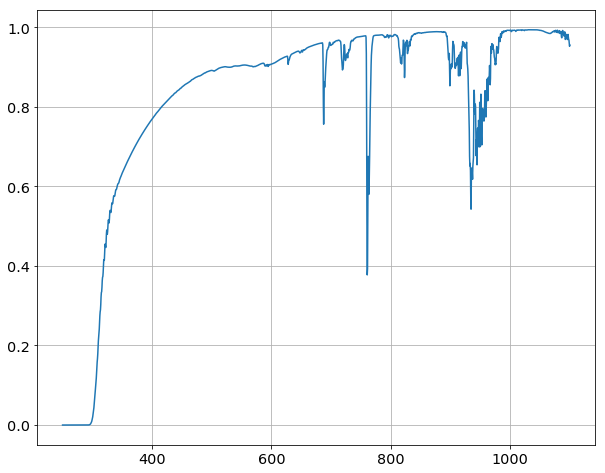

In [15]:
plt.plot(wl,COMBIN_TRANS)
plt.grid(True)